In [ ]:
from google.colab import files
files.upload()

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d splcher/animefacedataset
!unzip -qq animefacedataset.zip

Saving kaggle.json to kaggle.json
 94% 370M/395M [00:01<00:00, 245MB/s]
100% 395M/395M [00:01<00:00, 227MB/s]


In [ ]:
import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
from torch.nn import functional as F

image_size = 64
batch_size = 64

train_ds = ImageFolder(
    './anime/',
    transform = transforms.Compose([transforms.Resize([image_size,image_size]), transforms.ToTensor()])
)

train_dl = DataLoader(train_ds, batch_size)


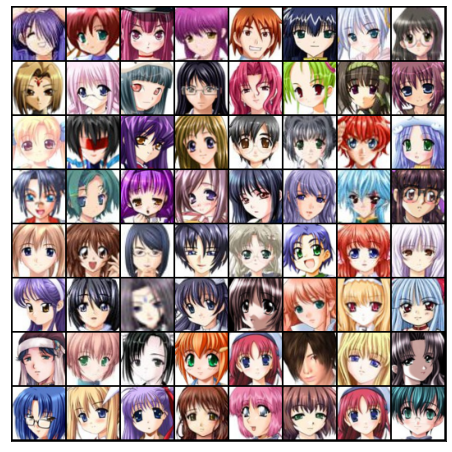

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=8).permute(1,2,0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

show_batch(train_dl)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
class VanillaVAE(nn.Module):
    def __init__(self, in_channels=3 , latent_dim = 200, hidden_dims = None):
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i+1],
                                       kernel_size = 3,
                                       stride = 2,
                                       padding = 1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU()
                )
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                              hidden_dims[-1],
                              kernel_size=3,
                              stride=2,
                              padding=1,
                              output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return [mu, log_var]

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 2, 2)
        z = self.decoder(z)
        z = self.final_layer(z)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, **kwargs):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), x, mu, log_var]

    def loss_f(self, *args, **kwargs):
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}

    def sample (self, num_samples, current_device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        return self.forward(x)[0]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VanillaVAE().to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [ ]:
from tqdm import tqdm

num_epochs = 100
epoch_train_loss=[]
for epoch in range(num_epochs):
    for i, (x, _) in tqdm(enumerate(train_dl)):
        # 获取样本，并前向传播
        x = x.to(device)
        x_reconst,_ , mu, log_var = model(x)

        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播和优化
        loss = reconst_loss + kl_div
        epoch_train_loss.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f"Epoch: {epoch+ 1}/{num_epochs} Loss: {reconst_loss.item()}")


0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
994it [00:52, 19.06it/s]


Epoch: 1/100 Loss: 83919.703125


994it [00:53, 18.60it/s]


Epoch: 2/100 Loss: 83816.25


994it [00:50, 19.75it/s]


Epoch: 3/100 Loss: 83857.984375


994it [00:50, 19.75it/s]


Epoch: 4/100 Loss: 83982.2109375


994it [00:50, 19.84it/s]


Epoch: 5/100 Loss: 83825.2578125


994it [00:51, 19.40it/s]


Epoch: 6/100 Loss: 83783.53125


994it [00:50, 19.83it/s]


Epoch: 7/100 Loss: 83722.28125


994it [00:50, 19.82it/s]


Epoch: 8/100 Loss: 83738.5078125


994it [00:50, 19.76it/s]


Epoch: 9/100 Loss: 83714.8125


994it [00:50, 19.49it/s]


Epoch: 10/100 Loss: 83697.609375


994it [00:50, 19.76it/s]


Epoch: 11/100 Loss: 83700.359375


994it [00:50, 19.61it/s]


Epoch: 12/100 Loss: 83755.3125


994it [00:51, 19.33it/s]


Epoch: 13/100 Loss: 83764.0


994it [00:50, 19.73it/s]


Epoch: 14/100 Loss: 83704.4921875


994it [00:50, 19.75it/s]


Epoch: 15/100 Loss: 83601.859375


994it [00:50, 19.68it/s]


Epoch: 16/100 Loss: 83674.1171875


994it [00:51, 19.48it/s]


Epoch: 17/100 Loss: 83606.65625


994it [00:50, 19.75it/s]


Epoch: 18/100 Loss: 83691.2109375


994it [00:50, 19.75it/s]


Epoch: 19/100 Loss: 83595.078125


994it [00:50, 19.74it/s]


Epoch: 20/100 Loss: 83512.0625


994it [00:50, 19.62it/s]


Epoch: 21/100 Loss: 83663.25


694it [00:35, 19.43it/s]

In [ ]:
x = next(iter(train_dl))

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(x[0]):
    ax = fig.add_subplot(8, 8, ii + 1, xticks=[], yticks=[])
    img = img.numpy().transpose(1,2,0)
    plt.imshow(img)

In [ ]:
x = next(iter(train_dl))
x = x[0]
recon = model.generate(x.to(device))
fig = plt.figure(figsize=(25, 16))
for i in range(len(recon)):
    ax = fig.add_subplot(8, 1, i + 1, xticks=[], yticks=[])
    img = recon[i].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(img)

In [ ]:
from PIL import Image

image = Image.open("/content/2022-12-27_23-17.png")
plt.subplot(1,2,1)
plt.imshow(image)
transform = transforms.Compose([transforms.Resize([image_size,image_size]), transforms.ToTensor()])
image = transform(image)
image = image.unsqueeze(0)


model.eval()
recon = model.generate(image.to(device))
img = recon.cpu().detach().numpy()

im2display = img[0].transpose((1,2,0))
plt.subplot(1,2,2)
plt.imshow(im2display, interpolation='nearest')

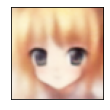

In [ ]:
samples = model.sample(64, device)
fig = plt.figure(figsize=(25, 16))
for i in range(len(recon)):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    img = samples[i].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(img)